# Artificial Neural Networks (ANNs)

Artificial Neural Networks (ANNs) are computational models inspired by biological neural networks. They consist of layers of interconnected nodes (neurons), where each connection has a weight. ANNs are powerful tools for approximating complex functions, making them widely used in regression, classification, and other tasks.

1. Input Layer: Receives input features $x = [x_1, x_2, \ldots, x_n]$.
2. Hidden Layers: Perform transformations using weighted connections and activation functions.
3. Output Layer: Produces predictions $\hat{y}$.

#### Mathematical Representation
For a single neuron, the output is computed as:
$$
z = \sum_{i=1}^n w_i x_i + b
$$
where $w_i$ are weights, and $b$ is the bias. This output is passed through an activation function $\phi$:
$$
a = \phi(z)
$$

For a multi-layer ANN, the outputs of one layer serve as inputs to the next:
$$
\mathbf{a}^{(l)} = \phi(\mathbf{W}^{(l)} \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)})
$$
where $\mathbf{W}^{(l)}$ and $\mathbf{b}^{(l)}$ are the weights and biases of layer $l$, respectively.

#### Training
ANNs are trained by minimizing a loss function $\mathcal{L}$ using optimization algorithms like Stochastic Gradient Descent (SGD). Gradients of the loss with respect to weights are computed using backpropagation:
$$
\theta \leftarrow \theta - \eta \nabla_\theta \mathcal{L}
$$
where $\eta$ is the learning rate, and $\theta$ represents the model parameters.

## Activation Functions
1. ReLU: $ \phi(z) = \max(0, z) $
2. Sigmoid: $ \phi(z) = \frac{1}{1 + e^{-z}} $
3. Tanh: $ \phi(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}} $

### Regression

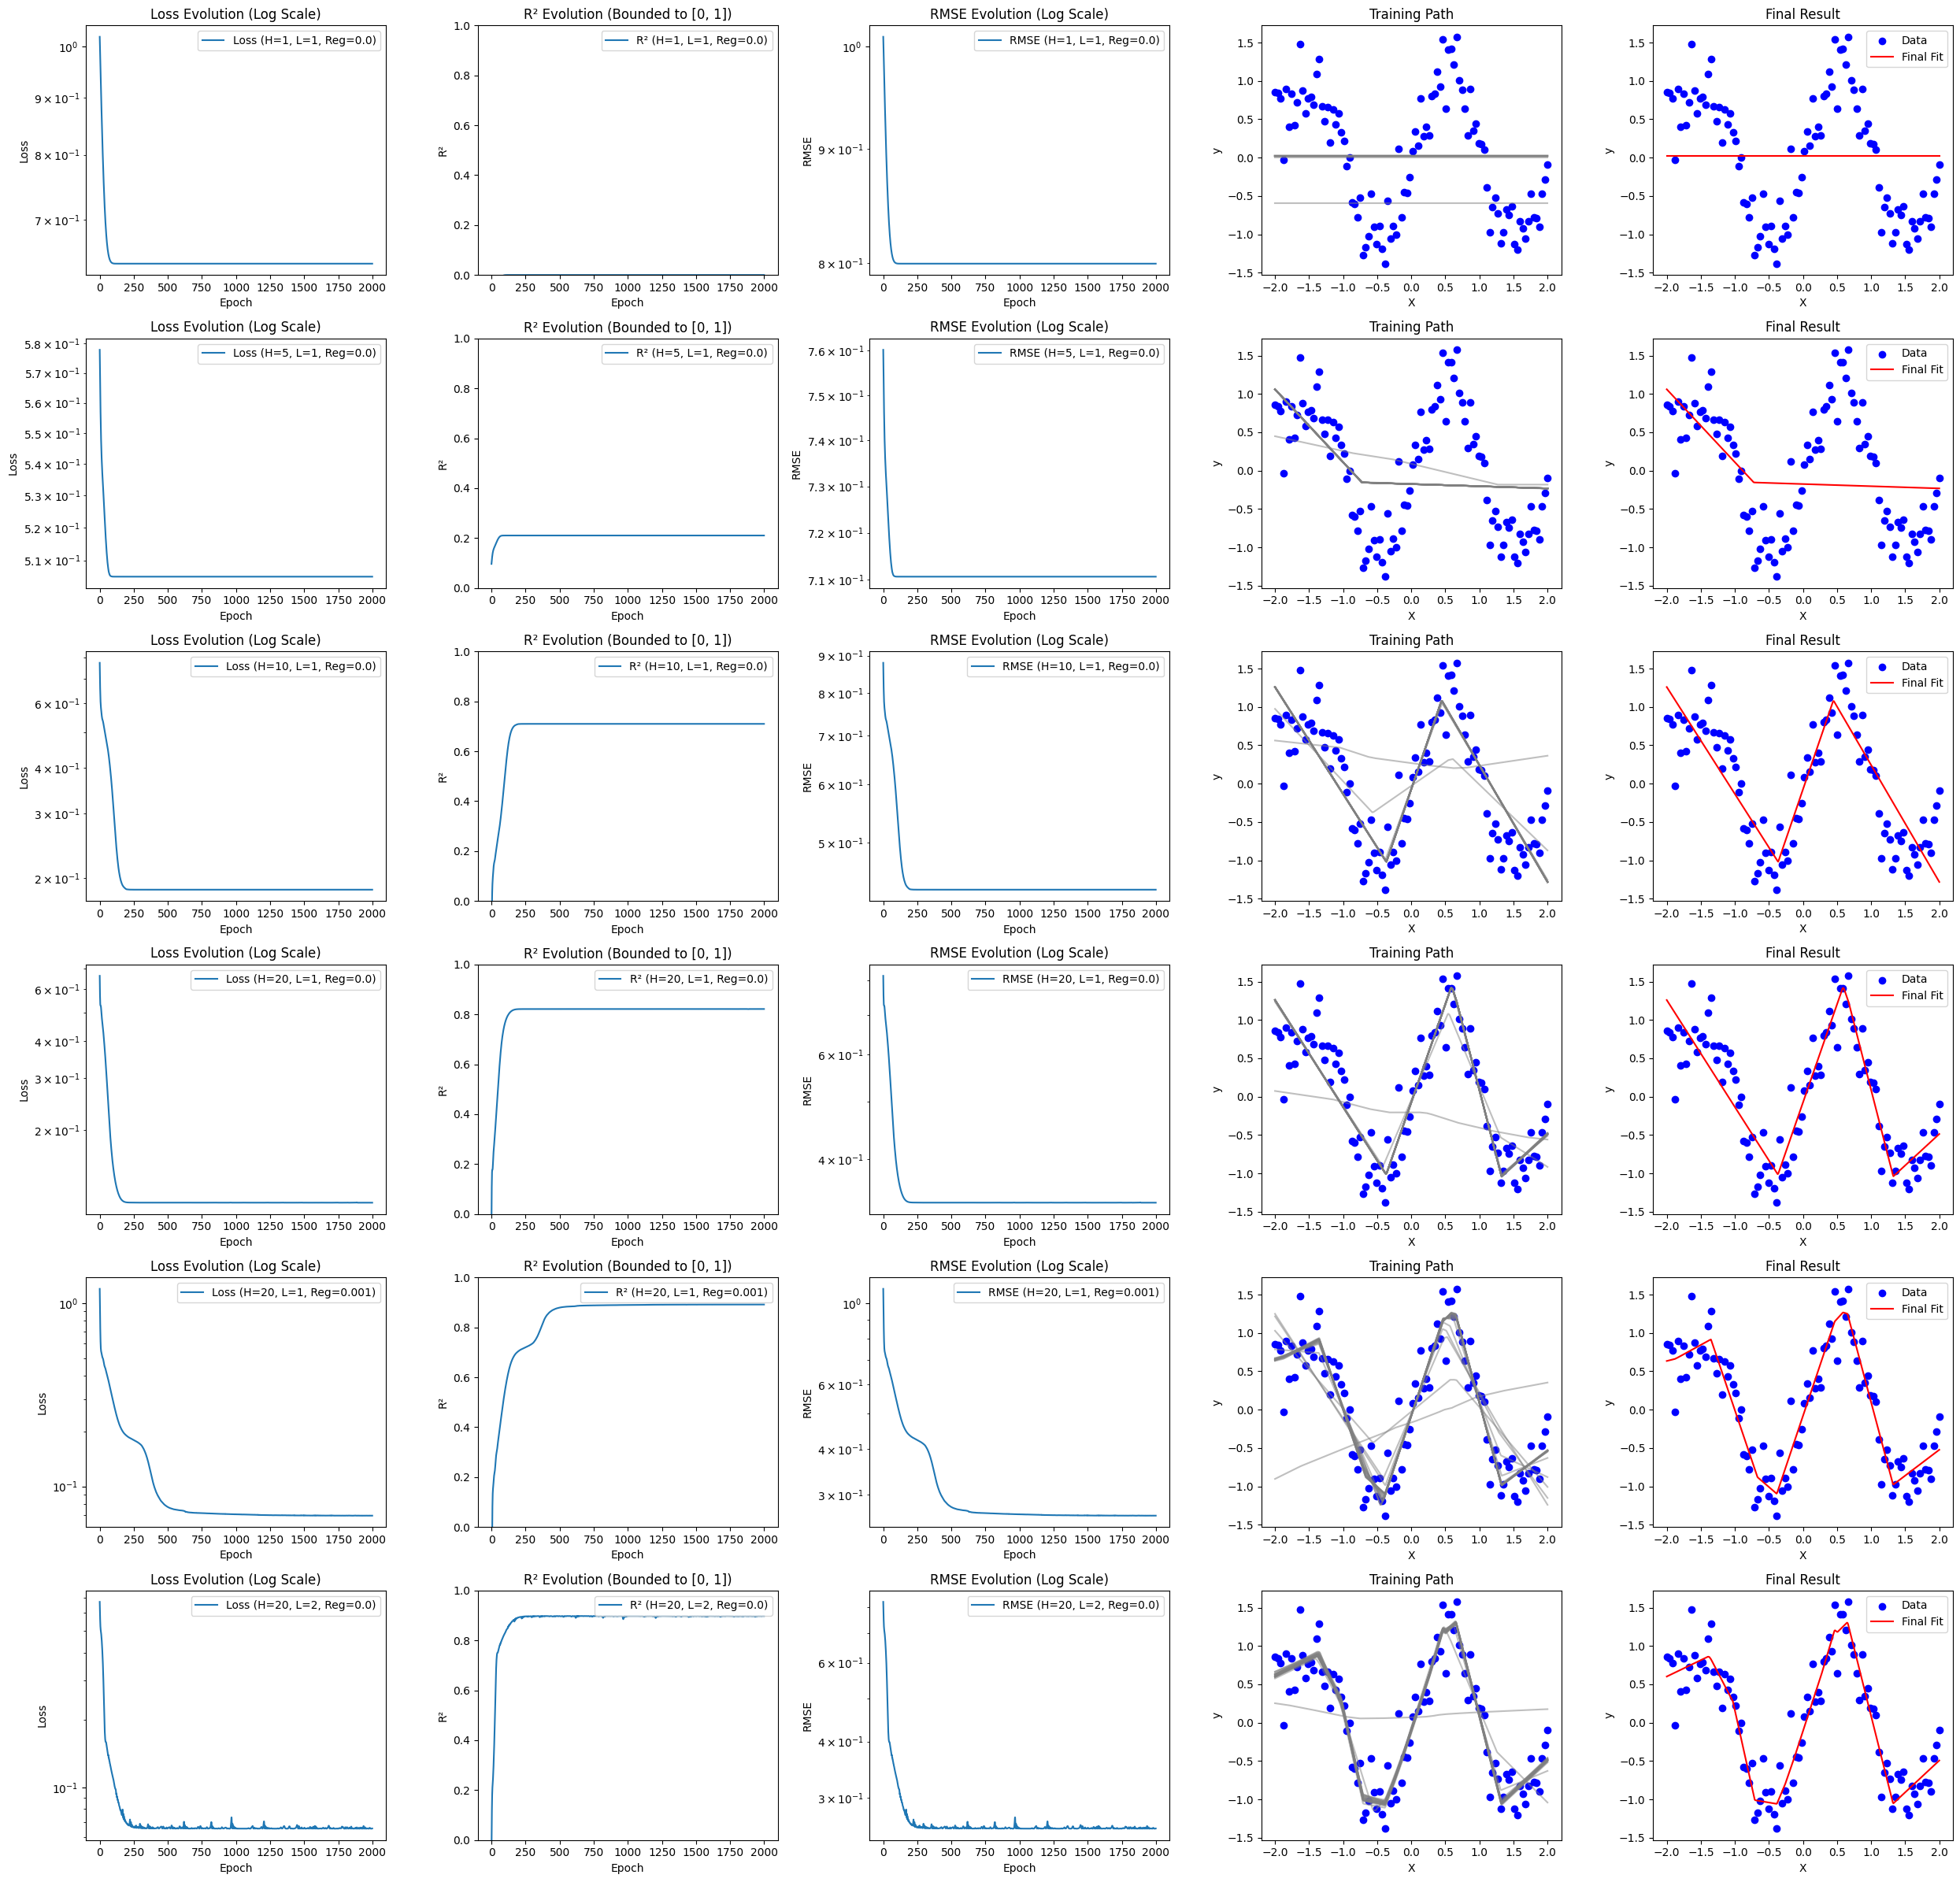

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define a simple ANN class
class SimpleANN(nn.Module):
    def __init__(self, hidden_size, layers=1, regularization=False):
        super(SimpleANN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(1 if i == 0 else hidden_size, hidden_size) for i in range(layers)])
        self.output = nn.Linear(hidden_size, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output(x)

# Function to train the ANN model
def train_ann(hidden_size, layers=1, epochs=2000, weight_decay=0.0):
    model = SimpleANN(hidden_size, layers)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    X_plot = torch.linspace(-2, 2, 500).unsqueeze(1)
    predictions_during_training = []
    loss_history = []
    r2_history = []
    rmse_history = []

    for epoch in range(epochs):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics
        with torch.no_grad():
            rmse = torch.sqrt(loss).item()
            ss_total = torch.sum((y - torch.mean(y))**2)
            ss_residual = torch.sum((y - y_pred)**2)
            r2 = 1 - (ss_residual / ss_total).item()

        # Store metrics
        loss_history.append(loss.item())
        rmse_history.append(rmse)
        r2_history.append(r2)

        # Store predictions every 100 epochs for visualization
        if epoch % 100 == 0 or epoch == epochs - 1:
            with torch.no_grad():
                y_plot = model(X_plot).detach()
                predictions_during_training.append((epoch, y_plot))

    return model, X_plot, predictions_during_training, loss_history, r2_history, rmse_history

# Generate synthetic data
torch.manual_seed(42)
X = torch.linspace(-2, 2, 100).unsqueeze(1)
y = torch.sin(3 * X) + 0.3 * torch.randn_like(X)

# Train models with different configurations
configurations = [
    (1, 1, 0.0),  # Single hidden layer, 1 unit
    (5, 1, 0.0),  # Single hidden layer, 5 units
    (10, 1, 0.0), # Single hidden layer, 10 units
    (20, 1, 0.0), # Single hidden layer, 20 units
    (20, 1, 0.001), # Single hidden layer, 20 units + regularization
    (20, 2, 0.0)  # Two hidden layers, each with 20 units
]

results = [train_ann(hidden_size, layers, weight_decay=reg) for hidden_size, layers, reg in configurations]

# Create subplots
fig, axes = plt.subplots(len(configurations), 5, figsize=(25, len(configurations) * 4))

for idx, ((hidden_size, layers, reg), (model, X_plot, predictions_during_training, loss_history, r2_history, rmse_history)) in enumerate(zip(configurations, results)):
    # Loss evolution
    axes[idx, 0].plot(range(len(loss_history)), loss_history, label=f"Loss (H={hidden_size}, L={layers}, Reg={reg})")
    axes[idx, 0].set_yscale("log")
    axes[idx, 0].set_title("Loss Evolution (Log Scale)")
    axes[idx, 0].set_xlabel("Epoch")
    axes[idx, 0].set_ylabel("Loss")
    axes[idx, 0].legend()

    # R² evolution
    axes[idx, 1].plot(range(len(r2_history)), r2_history, label=f"R² (H={hidden_size}, L={layers}, Reg={reg})")
    axes[idx, 1].set_title("R² Evolution (Bounded to [0, 1])")
    axes[idx, 1].set_xlabel("Epoch")
    axes[idx, 1].set_ylabel("R²")
    axes[idx, 1].set_ylim(0, 1)
    axes[idx, 1].legend()

    # RMSE evolution
    axes[idx, 2].plot(range(len(rmse_history)), rmse_history, label=f"RMSE (H={hidden_size}, L={layers}, Reg={reg})")
    axes[idx, 2].set_yscale("log")
    axes[idx, 2].set_title("RMSE Evolution (Log Scale)")
    axes[idx, 2].set_xlabel("Epoch")
    axes[idx, 2].set_ylabel("RMSE")
    axes[idx, 2].legend()

    # Training path (intermediate snapshots)
    axes[idx, 3].scatter(X.numpy(), y.numpy(), color="blue")
    for epoch, y_snapshot in predictions_during_training:
        axes[idx, 3].plot(X_plot.numpy(), y_snapshot.numpy(), color="gray", alpha=0.5)
    axes[idx, 3].set_title("Training Path")
    axes[idx, 3].set_xlabel("X")
    axes[idx, 3].set_ylabel("y")

    # Final result
    axes[idx, 4].scatter(X.numpy(), y.numpy(), color="blue", label="Data")
    y_final = model(X_plot).detach()
    axes[idx, 4].plot(X_plot.numpy(), y_final.numpy(), label="Final Fit", color="red")
    axes[idx, 4].set_title("Final Result")
    axes[idx, 4].set_xlabel("X")
    axes[idx, 4].set_ylabel("y")
    axes[idx, 4].legend()

plt.tight_layout()
plt.show()


### Classification

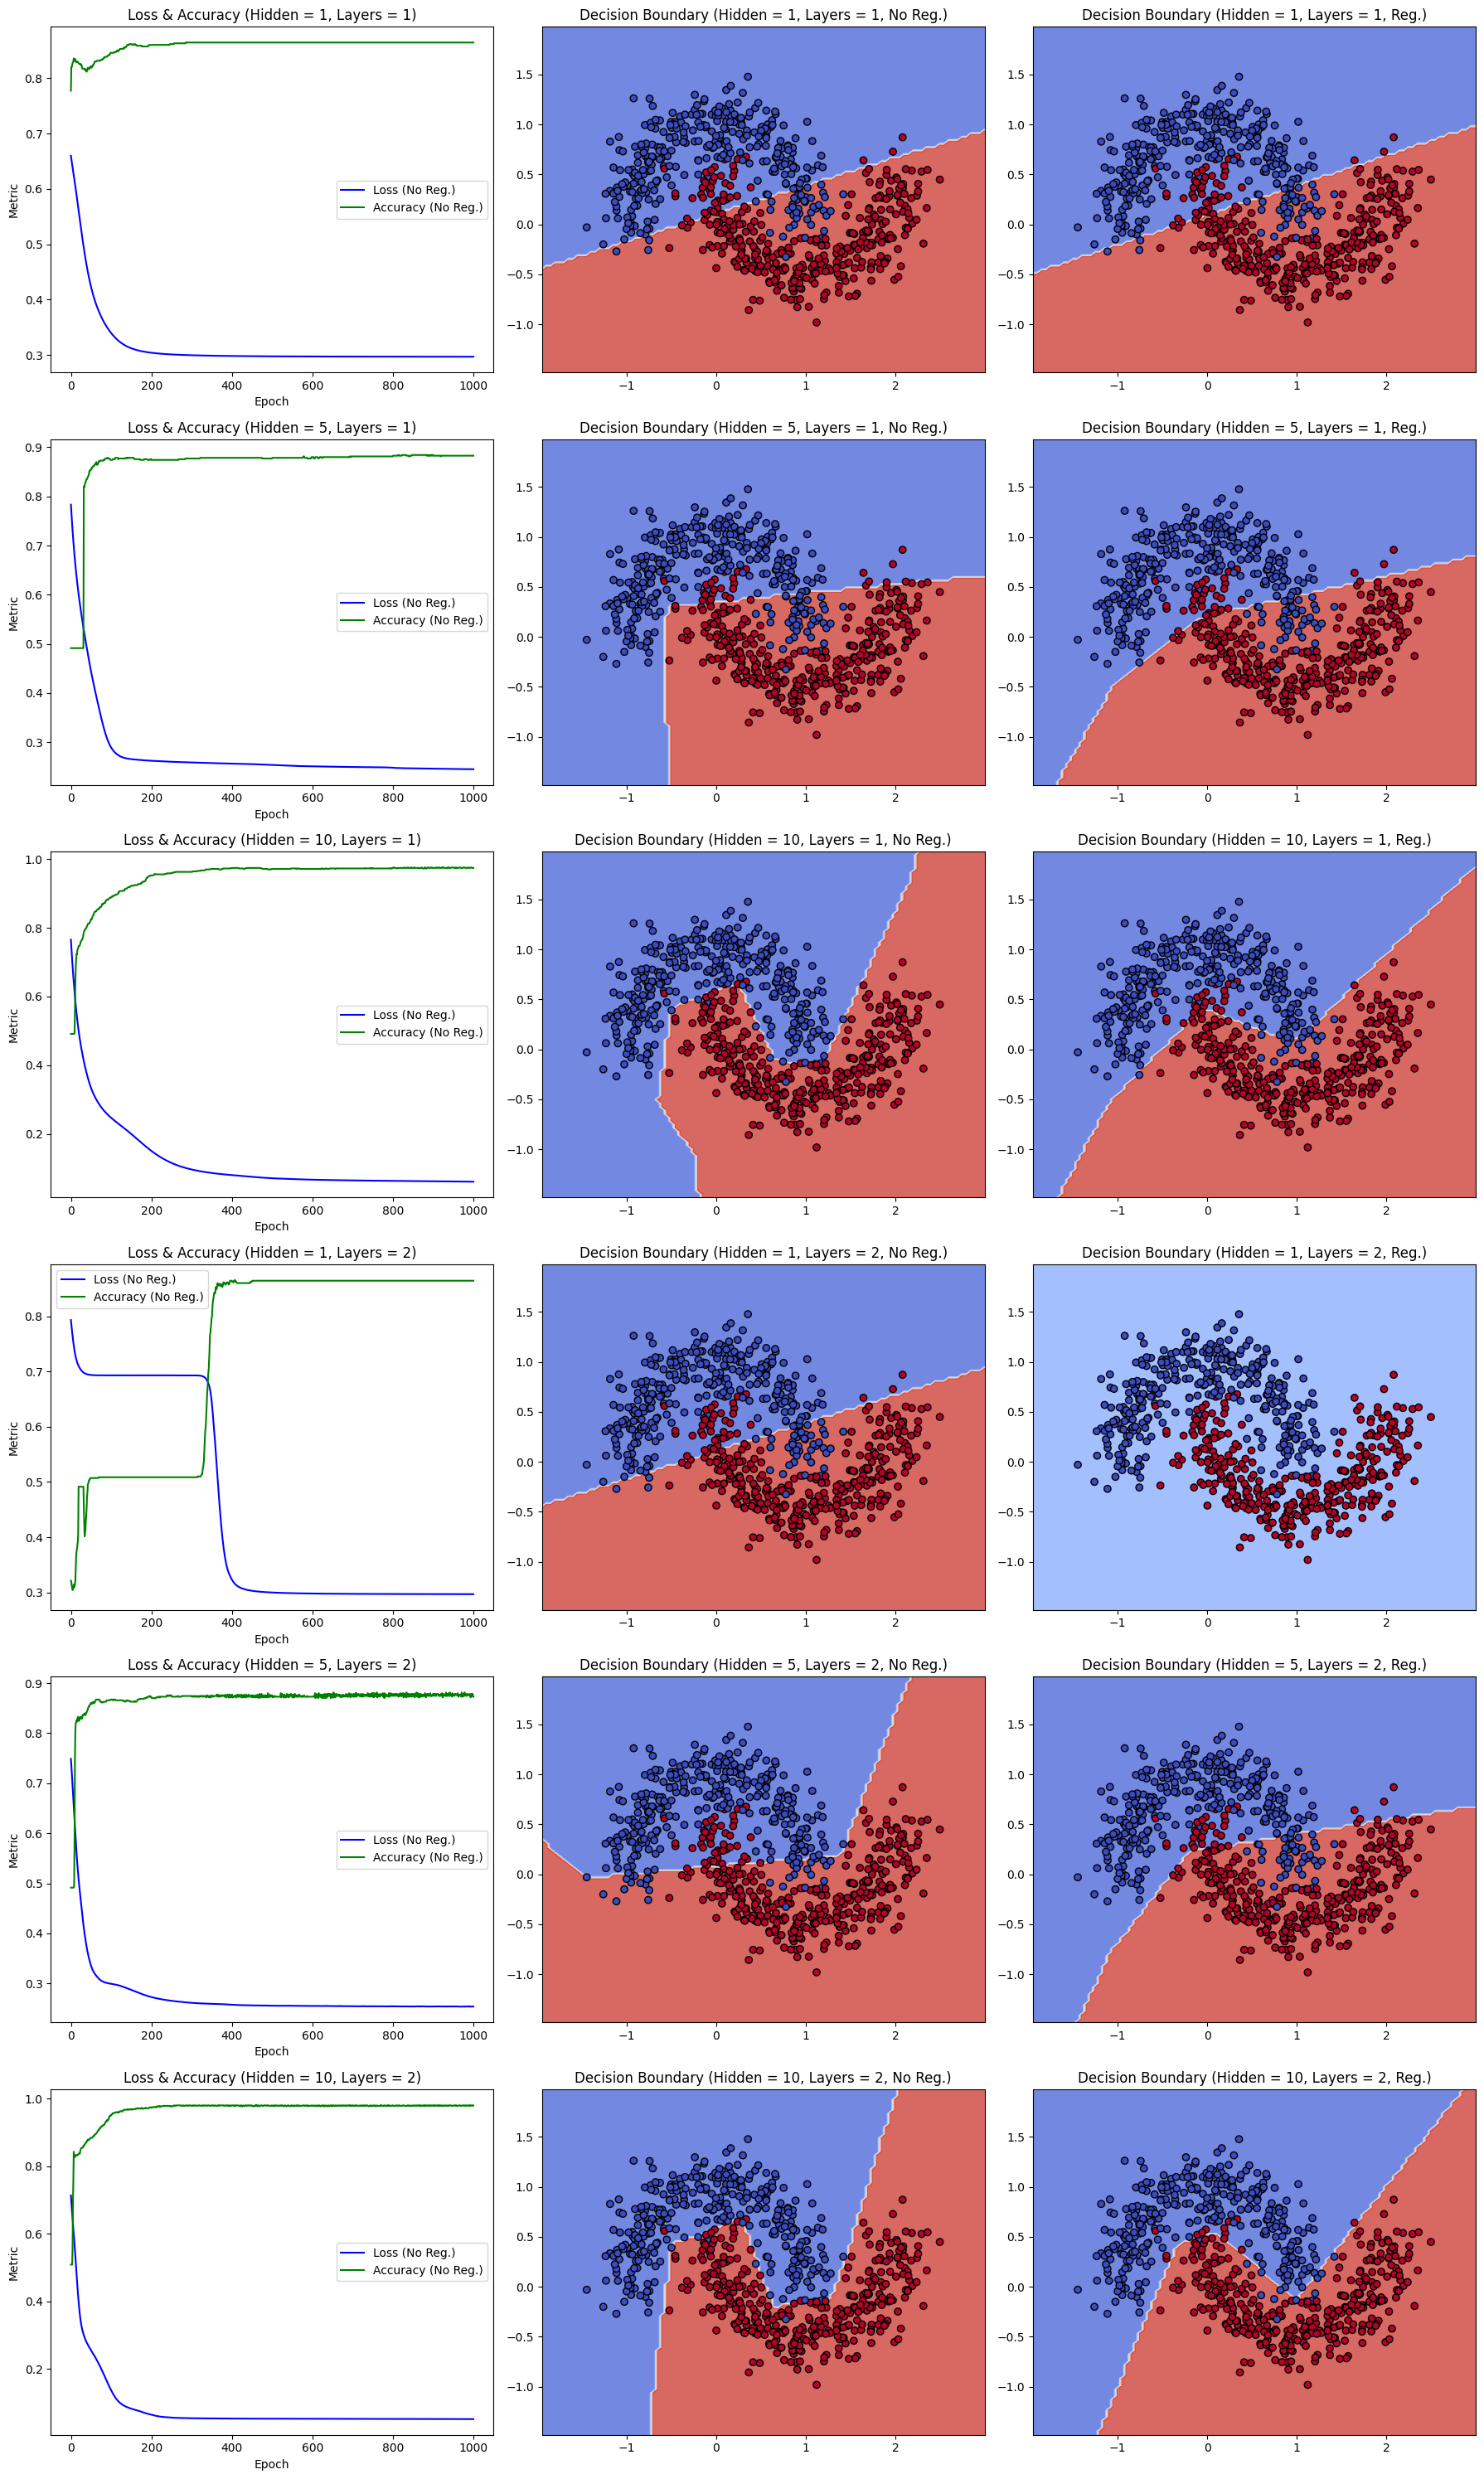

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generate moons dataset
X_moons, y_moons = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.3, random_state=42)

# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define ANN for classification
class MoonsANN(nn.Module):
    def __init__(self, hidden_size, layers=1):
        super(MoonsANN, self).__init__()
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(2 if i == 0 else hidden_size, hidden_size) for i in range(layers)]
        )
        self.output = nn.Linear(hidden_size, 2)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output(x)
        return x

# Training function
def train_moons_ann(hidden_size, layers=1, weight_decay=0.0, epochs=1000):
    model = MoonsANN(hidden_size, layers)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_history = []
    train_accuracy_history = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            train_loss = loss.item()
            train_accuracy = (y_pred.argmax(dim=1) == y_train).float().mean().item()
            train_loss_history.append(train_loss)
            train_accuracy_history.append(train_accuracy)
    
    return model, train_loss_history, train_accuracy_history

# Train models for different configurations
results = {}
configurations = [
    {"hidden_size": size, "layers": 1} for size in [1, 5, 10]
] + [
    {"hidden_size": size, "layers": 2} for size in [1, 5, 10]
]

for config in configurations:
    hidden_size = config["hidden_size"]
    layers = config["layers"]
    results[(hidden_size, layers)] = {
        "no_reg": train_moons_ann(hidden_size=hidden_size, layers=layers),
        "reg": train_moons_ann(hidden_size=hidden_size, layers=layers, weight_decay=0.01)
    }

# Decision boundary function
def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100),
                            torch.linspace(y_min, y_max, 100))
    grid = torch.cat([xx.ravel().unsqueeze(1), yy.ravel().unsqueeze(1)], dim=1)
    with torch.no_grad():
        Z = model(grid).argmax(dim=1).reshape(xx.shape)
    ax.contourf(xx, yy, Z.numpy(), alpha=0.8, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap='coolwarm')
    ax.set_title(title)

# Plot results in an MxN grid
fig, axes = plt.subplots(6, 3, figsize=(18, 30))

for i, config in enumerate(configurations):
    hidden_size = config["hidden_size"]
    layers = config["layers"]

    # Plot loss and accuracy evolution
    model_no_reg, train_loss, train_acc = results[(hidden_size, layers)]["no_reg"]
    axes[i, 0].plot(range(len(train_loss)), train_loss, label="Loss (No Reg.)", color="blue")
    axes[i, 0].plot(range(len(train_acc)), train_acc, label="Accuracy (No Reg.)", color="green")
    axes[i, 0].set_title(f"Loss & Accuracy (Hidden = {hidden_size}, Layers = {layers})")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Metric")
    axes[i, 0].legend()

    # Plot decision boundary without regularization
    plot_decision_boundary(
        model_no_reg, X_train.numpy(), y_train.numpy(), axes[i, 1],
        f"Decision Boundary (Hidden = {hidden_size}, Layers = {layers}, No Reg.)"
    )

    # Plot decision boundary with regularization
    model_reg, _, _ = results[(hidden_size, layers)]["reg"]
    plot_decision_boundary(
        model_reg, X_train.numpy(), y_train.numpy(), axes[i, 2],
        f"Decision Boundary (Hidden = {hidden_size}, Layers = {layers}, Reg.)"
    )

plt.tight_layout()
plt.show()


### Multiclassification

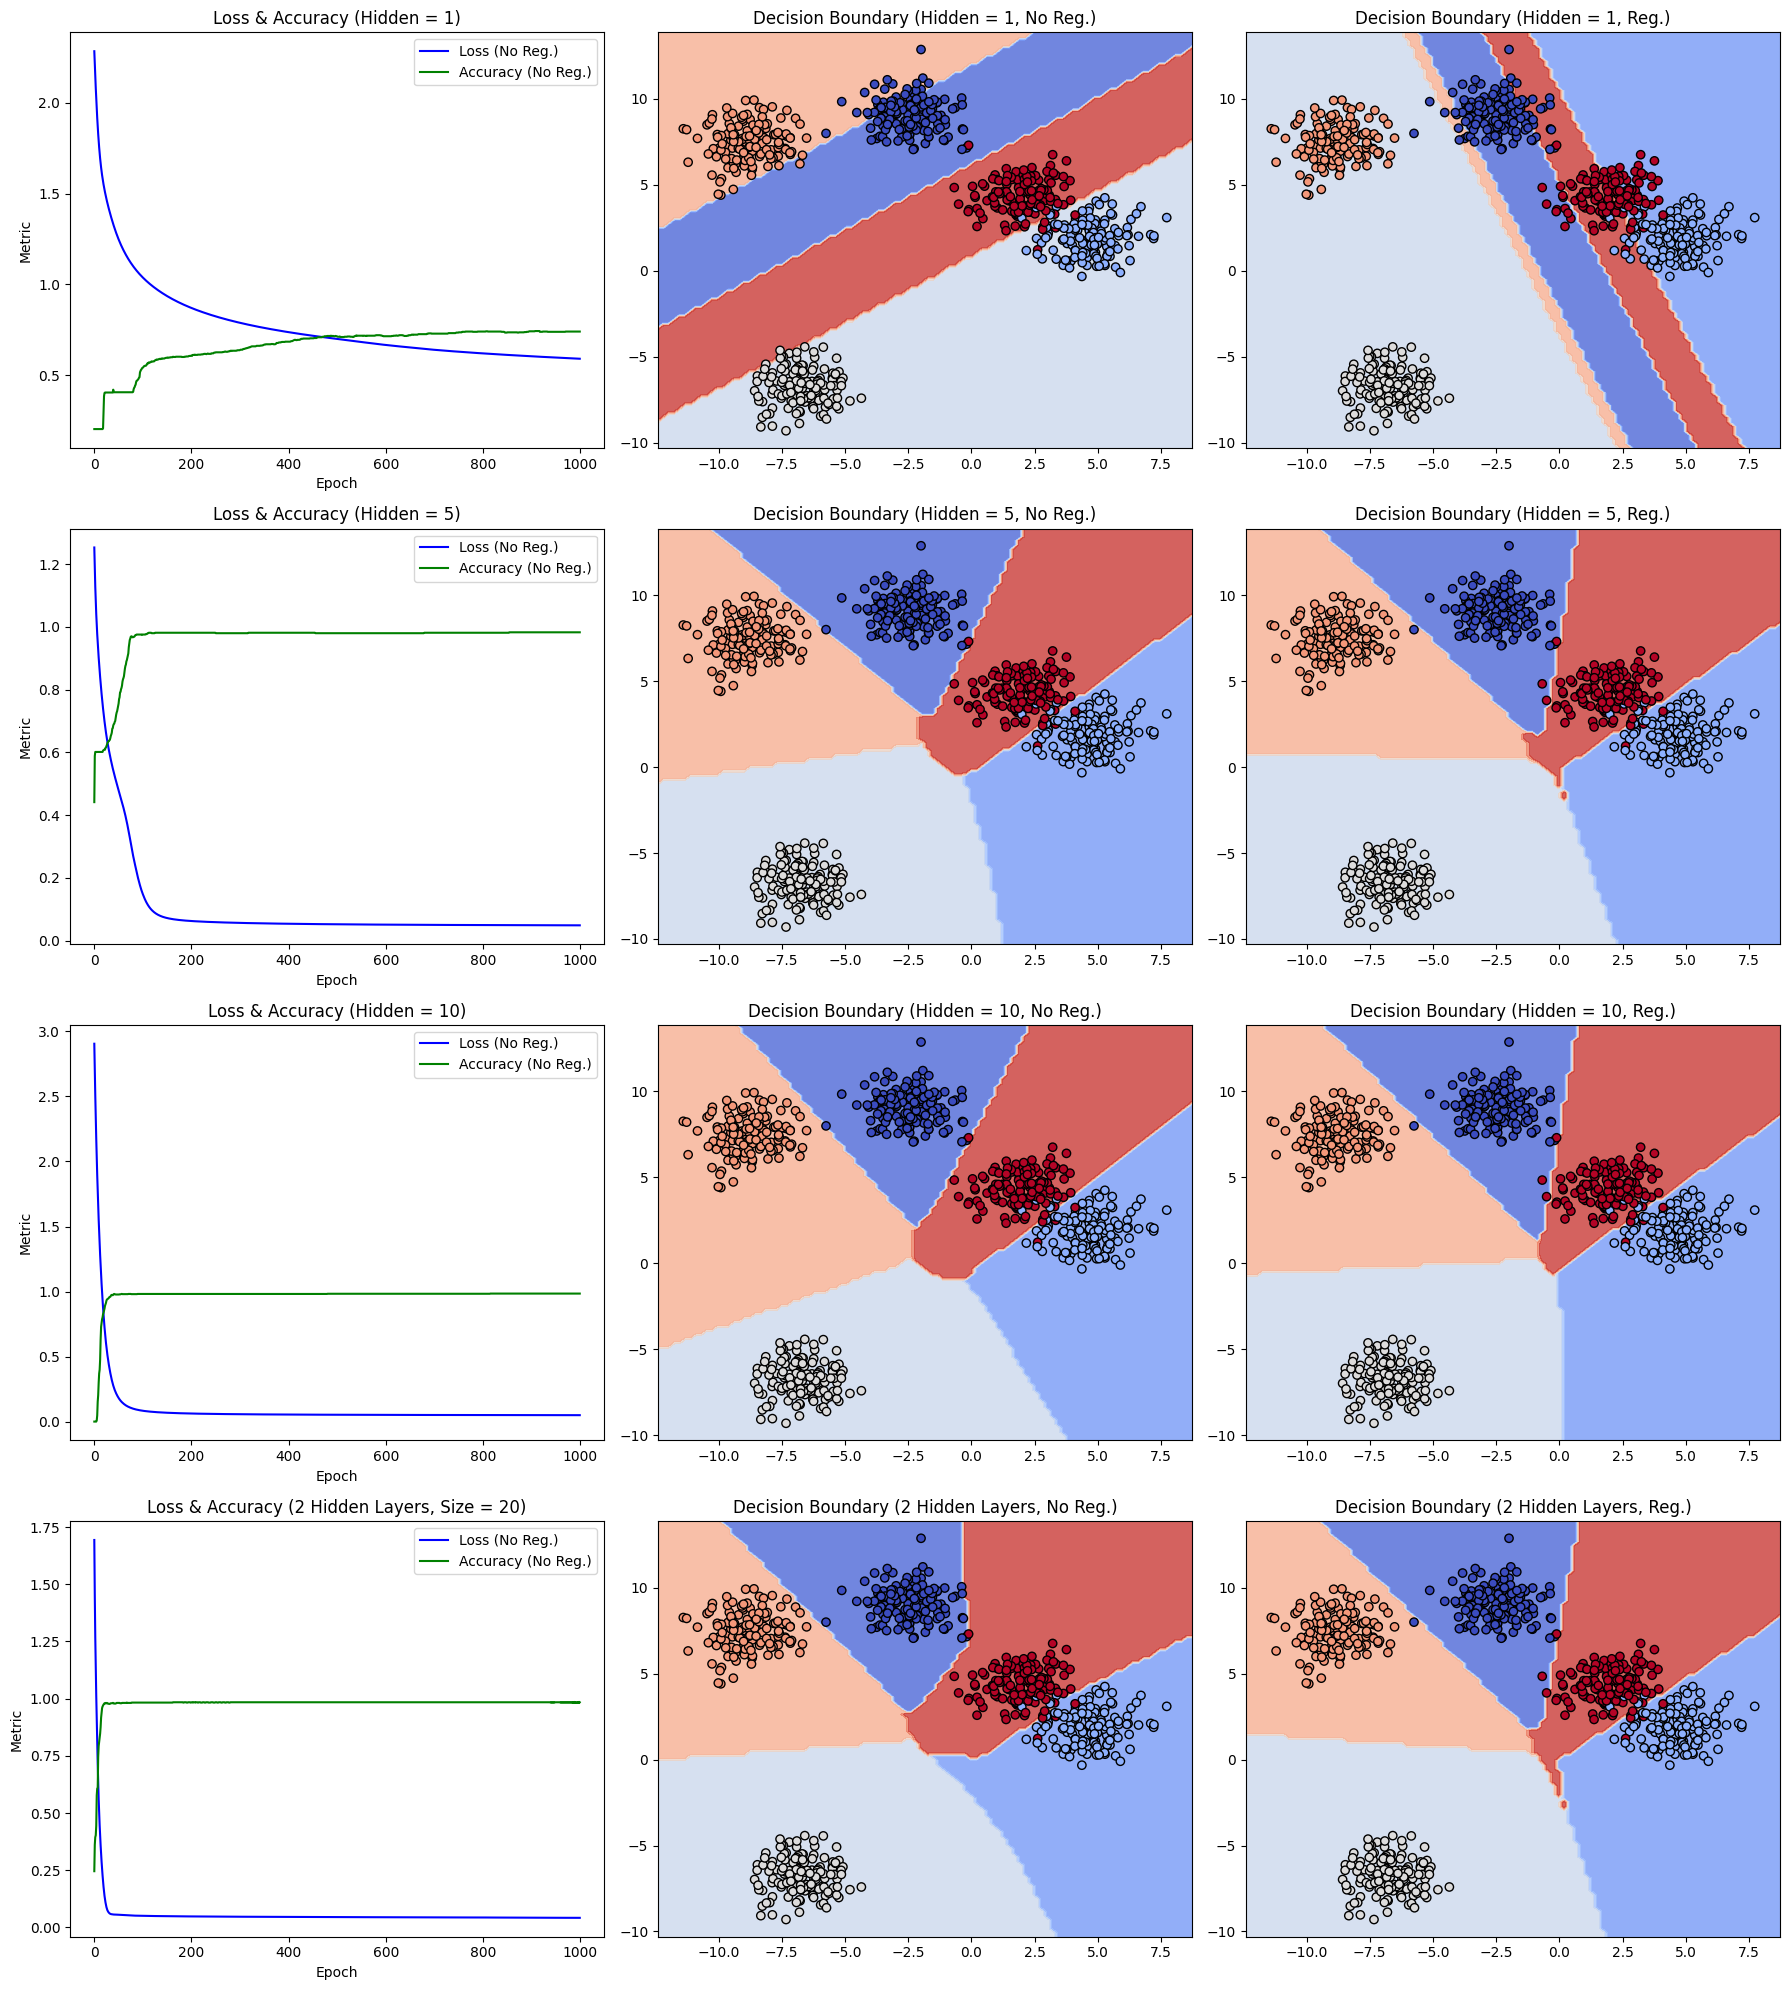

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Generate synthetic multi-class dataset with 5 classes
X_blobs, y_blobs = make_blobs(n_samples=1000, centers=5, cluster_std=1.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_blobs, y_blobs, test_size=0.3, random_state=42)

# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define ANN for multi-class classification (single hidden layer)
class MultiClassANN(nn.Module):
    def __init__(self, hidden_size):
        super(MultiClassANN, self).__init__()
        self.hidden = nn.Linear(2, hidden_size)
        self.output = nn.Linear(hidden_size, 5)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

# Define ANN for multi-class classification (two hidden layers)
class MultiClassANN2Hidden(nn.Module):
    def __init__(self, hidden_size):
        super(MultiClassANN2Hidden, self).__init__()
        self.hidden1 = nn.Linear(2, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 5)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.output(x)
        return x

# Training function
def train_multiclass_ann(model_class, hidden_size, weight_decay=0.0, epochs=1000):
    model = model_class(hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_history = []
    train_accuracy_history = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            train_loss = loss.item()
            train_accuracy = (y_pred.argmax(dim=1) == y_train).float().mean().item()
            train_loss_history.append(train_loss)
            train_accuracy_history.append(train_accuracy)
    
    return model, train_loss_history, train_accuracy_history

# Train single-layer models for hidden layer sizes 1, 5, 10
results = {}
hidden_sizes = [1, 5, 10]
for size in hidden_sizes:
    results[size] = {
        "no_reg": train_multiclass_ann(MultiClassANN, hidden_size=size),
        "reg": train_multiclass_ann(MultiClassANN, hidden_size=size, weight_decay=0.01)
    }

# Train two-layer model
results_2hidden = {
    "no_reg": train_multiclass_ann(MultiClassANN2Hidden, hidden_size=20),
    "reg": train_multiclass_ann(MultiClassANN2Hidden, hidden_size=20, weight_decay=0.01)
}

# Decision boundary function
def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100),
                            torch.linspace(y_min, y_max, 100))
    grid = torch.cat([xx.ravel().unsqueeze(1), yy.ravel().unsqueeze(1)], dim=1)
    with torch.no_grad():
        Z = model(grid).argmax(dim=1).reshape(xx.shape)
    ax.contourf(xx, yy, Z.numpy(), alpha=0.8, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap='coolwarm')
    ax.set_title(title)

# Plot results in an expanded MxN grid
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

# Single-layer models (Rows 1-3)
for i, size in enumerate(hidden_sizes):
    # Plot loss and accuracy evolution
    model_no_reg, train_loss, train_acc = results[size]["no_reg"]
    axes[i, 0].plot(range(len(train_loss)), train_loss, label="Loss (No Reg.)", color="blue")
    axes[i, 0].plot(range(len(train_acc)), train_acc, label="Accuracy (No Reg.)", color="green")
    axes[i, 0].set_title(f"Loss & Accuracy (Hidden = {size})")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Metric")
    axes[i, 0].legend()

    # Plot decision boundary without regularization
    plot_decision_boundary(model_no_reg, X_train.numpy(), y_train.numpy(), axes[i, 1],
                           f"Decision Boundary (Hidden = {size}, No Reg.)")

    # Plot decision boundary with regularization
    model_reg, _, _ = results[size]["reg"]
    plot_decision_boundary(model_reg, X_train.numpy(), y_train.numpy(), axes[i, 2],
                           f"Decision Boundary (Hidden = {size}, Reg.)")

# Two-layer models (Row 4)
model_no_reg, train_loss, train_acc = results_2hidden["no_reg"]
axes[3, 0].plot(range(len(train_loss)), train_loss, label="Loss (No Reg.)", color="blue")
axes[3, 0].plot(range(len(train_acc)), train_acc, label="Accuracy (No Reg.)", color="green")
axes[3, 0].set_title(f"Loss & Accuracy (2 Hidden Layers, Size = 20)")
axes[3, 0].set_xlabel("Epoch")
axes[3, 0].set_ylabel("Metric")
axes[3, 0].legend()

# Decision boundary without regularization for 2 hidden layers
plot_decision_boundary(model_no_reg, X_train.numpy(), y_train.numpy(), axes[3, 1],
                       f"Decision Boundary (2 Hidden Layers, No Reg.)")

# Decision boundary with regularization for 2 hidden layers
model_reg, _, _ = results_2hidden["reg"]
plot_decision_boundary(model_reg, X_train.numpy(), y_train.numpy(), axes[3, 2],
                       f"Decision Boundary (2 Hidden Layers, Reg.)")

plt.tight_layout()
plt.show()


# Questions and Answers

1. Why is ReLU a preferred activation function in many ANN models?
- ReLU avoids the vanishing gradient problem common with Sigmoid and Tanh. Its sparsity (output of zero for negative inputs) also helps reduce computational overhead.

2. How can an ANN approximate any function?
- By the universal approximation theorem, an ANN with at least one hidden layer and non-linear activation functions can approximate any continuous function given sufficient neurons and data.

3. What is the effect of increasing the number of hidden neurons?
- Increasing the number of neurons can improve the network's capacity to learn complex patterns but may lead to overfitting if not regularized properly.

4. Why do we use CrossEntropyLoss for classification tasks?
- CrossEntropyLoss combines LogSoftmax and NLLLoss (negative log likelihood loss), which is ideal for multi-class classification tasks.

5. What challenges arise in training deep ANNs?
- Challenges include vanishing/exploding gradients, overfitting, and high computational requirements. Techniques like batch normalization, dropout, and adaptive optimizers mitigate these issues.
